In [1]:
# Based on Erik's script: plotting_NEMO.ipynb
%pylab inline
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
#import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from matplotlib.patches import Polygon, Ellipse
from glob import glob
import cmocean.cm as cmo
import gsw
import pickle

# Added this (from a forum) as a temporary fix to error I was getting regarding 'GeoAxes not having a _hold function'
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


Populating the interactive namespace from numpy and matplotlib


In [3]:
datadir = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/'
datadir_bgc = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/' 
dirread_mesh = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/domain/' 

xslice = slice(0, 4300)
yslice = slice(0, 3057)
nav_lon = xr.open_dataset(dirread_mesh+'coordinates.nc',decode_times=False).nav_lon.sel(x=xslice, y = yslice) 
nav_lat = xr.open_dataset(dirread_mesh+'coordinates.nc',decode_times=False).nav_lat.sel(x=xslice, y = yslice) 
# nav_lat = nav_lat.fillna(0.)

# ''' Shifting longitude to be continuously increasing ''' 
# #lon_shift = np.zeros((len(nav_lat[:,0]),len(nav_lat[0,:])))
# for ii in range(len(nav_lon[:,0])):
#     f = nav_lon[ii,0]
#     lon1 = nav_lon[ii,:]
#     ind = np.where(lon1>=f)[0]
#     #lon_shift[ii,:] = nav_lon[ii,:]
#     nav_lon[ii,ind] = nav_lon[ii,ind]-360

100% (4 of 4) |##########################| Elapsed Time: 0:01:46 Time:  0:01:46
100% (4 of 4) |##########################| Elapsed Time: 0:04:25 Time:  0:04:25


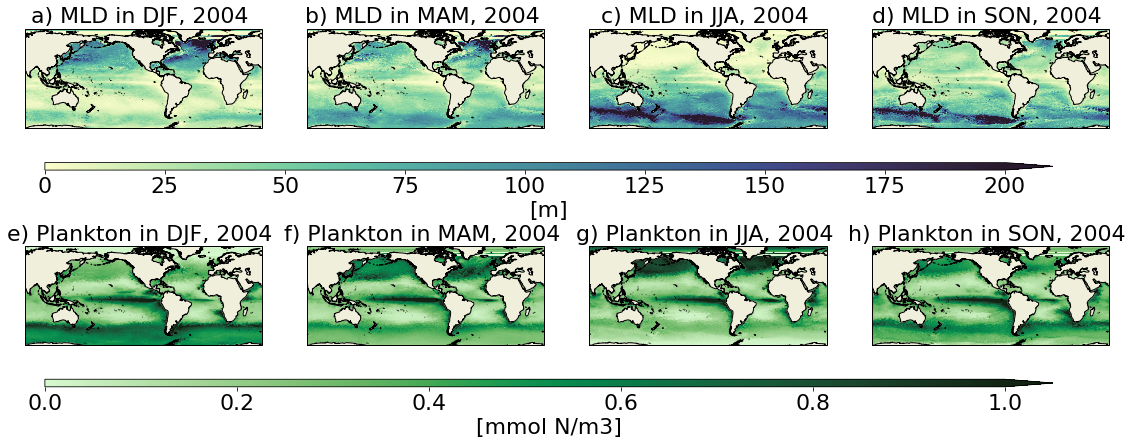

In [22]:
## To plot the MLD and phytoplankton subplots in one figure 

from time import sleep
from progressbar import progressbar

''' Preparing the projection and subplots'''
projection = cartopy.crs.PlateCarree(central_longitude=72+180) #PlateCarree() #central_longitude=0)
fig = plt.figure(figsize=(20, 7), constrained_layout=False) #True) # 10,5
gs = fig.add_gridspec(figure = fig, nrows = 4, ncols = 4, height_ratios=[10,1,10,1], wspace = 0.05, hspace = 1) # gridspec.GridSpec

''' Extract all files within a season into one variable '''

seasnames = ['DJF', 'MAM', 'JJA', 'SON']
monvals = ['12','01','02','03','04','05','06','07','08','09','10','11']


# parameters = {'axes.labelsize': 22,
#               'axes.titlesize': 22}
# plt.rcParams.update(parameters)

for row in range(2):
    for col in progressbar(range(4)):
        sleep(0.02)
        i = row*4 + col
        seas = seasnames[col]
        yr0 = '2004'
        yr1 = '2004'

        ai = fig.add_subplot(gs[row*2, col], projection=projection)
        ai.coastlines(resolution='50m',zorder=3)
        ai.add_feature(cartopy.feature.LAND, zorder=2)
        ai.set_ylim([-70, 80]) #,crs=cartopy.crs.PlateCarree())

        if col == 0: 
            yr0 = '2003'
            mons = monvals[0:3]
        if col == 1: 
            mons = monvals[3:6]
        if col == 2: 
            mons = monvals[6:9]
        if col == 3: 
            mons = monvals[9:12]

        if i < 4:           
            M0 = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_%s%s*d05T.nc' % (yr0,mons[0]) )+ glob(datadir+'ORCA0083-N06_%s%s*d05T.nc' % (yr1,mons[1]))+ 
                                          glob(datadir+'ORCA0083-N06_%s%s*d05T.nc'% (yr1,mons[2]))),combine='by_coords').mldr10_1.sel(x=xslice).mean('time_counter')     
            M0 = M0.assign_coords(nav_lat=M0.nav_lat.fillna(0.))
            M0 = M0.assign_coords(nav_lon=M0.nav_lon.where(M0.nav_lon<72, M0.nav_lon-360)) 

            a = M0.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=200, rasterized=True, cmap=cmo.deep, zorder = 1, transform=cartopy.crs.PlateCarree()) 
            title = 'MLD in %s, 2004' % seas

        if i > 3:           
            M1 = xr.open_mfdataset((glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc' % (yr0,mons[0]) )+ glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc' % (yr1,mons[1]))+ 
                                          glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc'% (yr1,mons[2]))),combine='by_coords').PHD.sel(x=xslice,deptht = slice(0,1)).mean('time_counter')

            M2 = xr.open_mfdataset((glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc' % (yr0,mons[0]) )+ glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc' % (yr1,mons[1]))+ 
                                          glob(datadir_bgc+'ORCA0083-N06_%s%s*d05P.nc'% (yr1,mons[2]))),combine='by_coords').PHN.sel(x=xslice,deptht = slice(0,1)).mean('time_counter') 
            M = M1[0]+M2[0]
            M = M.assign_coords(nav_lat=M0.nav_lat.fillna(0.))
            M = M.assign_coords(nav_lon=M0.nav_lon.where(M0.nav_lon<72, M0.nav_lon-360)) 

            a2 = M.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=1, rasterized=True, cmap=cmo.algae, zorder = 1, transform=cartopy.crs.PlateCarree()) 
            title = 'Plankton in %s, 2004' % seas
            
        ai.set_title('%s) %s ' % (chr(ord('a') + row*4 + col), title), fontsize = 22)

   # plt.title('Average mixed layer depth in Jan 2004')

cbaxes = fig.add_axes([0.15, 0.6, 0.7, 0.015]) # defines the x, y, w, h of the colorbar 
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m]', use_gridspec=True) #, fontsize = 22)
#cbaxes.ax.tick_params(labelsize=22)

cbaxes2 = fig.add_axes([0.15, 0.17, 0.7, 0.015]) # defines the x, y, w, h of the colorbar 
plt.colorbar(a2, cax=cbaxes2, orientation="horizontal", aspect=100, extend='max', label='[mmol N/m3]', use_gridspec=True) #, fontsize = 22)
#cbaxes2.ax.tick_params(labelsize=22)
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 22}

#plt.rc('font', size = 22)

fig.canvas.draw()
plt.tight_layout()
plt.savefig('/home/dlobelle/Kooi_figures/non_parcels_output/NEMO_MLD_phytoplank_allseas_2004.pdf')

In [53]:
'''Tests using 1 season for 2004 ELD'''

datadir = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/' 
dirread_mesh = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/domain/' 

# nav_lon = xr.open_dataset(dirread_mesh+'coordinates.nc',decode_times=False).nav_lon.sel(x=slice(0, 4319),y = slice(0,3057)) 
# nav_lat = xr.open_dataset(dirread_mesh+'coordinates.nc',decode_times=False).nav_lat.sel(x=slice(0, 4319),y = slice(0,3057)) 
# #nav_lon = nav_lon.where(nav_lon>72.91,nav_lon-360)
# nav_lat = nav_lat.fillna(0.)


eldfiles = xr.open_mfdataset((glob(datadir+'ORCA0083-N06_200401*d05D.nc')+ glob(datadir+'ORCA0083-N06_200402*d05D.nc')+ glob(datadir+'ORCA0083-N06_200403*d05D.nc')),combine='by_coords').MED_XZE.sel(x=slice(0, 4319),y = slice(0,3057)).mean('time_counter')
#eldfiles = mldfiles.assign_coords(nav_lat=mldfiles.nav_lat.fillna(0.))
# eldfiles = mldfiles.assign_coords(nav_lon.where(mldfiles.nav_lon<73, mldfiles.nav_lon-360))

eldfiles = mldfiles.assign_coords(nav_lon=nav_lon)
eldfiles = mldfiles.assign_coords(nav_lat=nav_lat)

#mld_mean = mldfiles.MED_XZE.mean(axis = 0)

projection = cartopy.crs.Mollweide() #Mollweide #central_longitude=-70.54164124) #73+180)
fig = plt.figure(figsize=(10,10), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])
ax = fig.add_subplot(gs[0], projection=projection)

ax.coastlines(resolution='50m', zorder=6)
ax.add_feature(cartopy.feature.LAND, zorder=5)
ax.set_ylim([-70, 60]) #,crs=cartopy.crs.PlateCarree())
#ax.set_extent([-180, 180, -70, 60]) #ax.set_extent([-287.08334, 73.00003, -70, 60]) #, crs=cartopy.crs.Mollweide())

#ax.set_extent([72.833336, -287.08334, -70, 60])

#ax.set_extent([-180, 180, -70, 70], crs=cartopy.crs.PlateCarree())
#ax.contourf(mld_mean['nav_lon'], mld_mean['nav_lat'], mld_mean['data'], transform = cartopy.crs.PlateCarree())

# Shifting longitude to be continuously increasing

#lon_shift = np.zeros((len(nav_lat[:,0]),len(nav_lat[0,:])))
# for ii in range(len(nav_lon[:,0])):
#     f = nav_lon[ii,0]
#     lon1 = nav_lon[ii,:]
#     ind = np.where(lon1>=f)[0]
#     #lon_shift[ii,:] = nav_lon[ii,:]
#     nav_lon[ii,ind] = nav_lon[ii,ind]-360

#lon_shift= xr.DataArray(lon_shift)
a = mldfiles.plot(x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=150, ax = ax, rasterized=True, zorder = 4) #, transform=cartopy.crs.PlateCarree(), rasterized=True) #norm=colors.LogNorm(vmin=0.01, vmax=1),
    
#a = mld_mean.plot(x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=150, ax = ax, rasterized=True, zorder = 4) #, transform=cartopy.crs.PlateCarree(), rasterized=True) #norm=colors.LogNorm(vmin=0.01, vmax=1),
#a = ax.pcolormesh(mldfiles.nav_lon, mldfiles.nav_lat, mld_mean, vmin=0, vmax=150, rasterized=True,transform=cartopy.crs.PlateCarree()) #, cmap=cmo.balance, zorder=-1)

plt.title('Average euphotic layer depth in DJF 2004')

cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
# savefig(fignum)

ValueError: conflicting sizes for dimension 'x': length 4300 on 'nav_lon' and length 4319 on 'nav_lat'